# I'm Something of a Painter Myself using GAN

Challenge problem: The goal of this project is to create a GAN model consisting of a generator and a discriminator neural network model. 7,000 to 10,000 monet style images will need to be generated and will be evaluated on how well it matches the style. This will be done through a cycle GAN neural network architecture.

Data: There are two datasets: one containing about 7000 photos worth of data and one that has around 300 monet style paintings worth of data. The data seems to be in the form of images, all being 256 by 256 pixels wide and tall. All images contain a range of multiple colors and are not black and white. This data is provided from the I'm Something of a Painter Myself kaggle competition in tfrec files.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import PIL
from IPython import display
import random

## EDA

In [2]:
# load in data from tfrecords

monetFilenames = tf.io.gfile.glob(str('data/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(monetFilenames))

photoFilenames = tf.io.gfile.glob(str('data/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(photoFilenames))


Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [3]:
# helper functions to read in the data from tfrec files

imageSize = [256, 256]
autotune = tf.data.experimental.AUTOTUNE
batchSize = 64
bufferSize = 1024

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*imageSize, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=autotune)
    return dataset

def get_dataset(filenames):
    return (
        load_dataset(filenames)
        .shuffle(bufferSize)
        .batch(batchSize)
        .prefetch(autotune)
    )

In [4]:
monetTrain = get_dataset(monetFilenames) # tensor dataset
photoTrain = get_dataset(photoFilenames)

# unbatch all photos and monet, gets the real count of monet/photos
photoTrainUnbatched = photoTrain.unbatch()
monetTrainUnbatched = monetTrain.unbatch()

monetCount = sum(1 for _ in monetTrainUnbatched)
photoCount = sum(1 for _ in photoTrainUnbatched)

print('monet dataset shape: ', monetTrain.element_spec.shape)
print('photo dataset shape: ', photoTrain.element_spec.shape)

print('monet images: ', monetCount)
print('photos: ', photoCount)

monet dataset shape:  (None, 256, 256, 3)
photo dataset shape:  (None, 256, 256, 3)
monet images:  300
photos:  7038


There are more photos than monet images. Some worries about overfitting to the photo's styles and not the style of the monet paintings.F

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8352941..0.8666667].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92941177].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow 

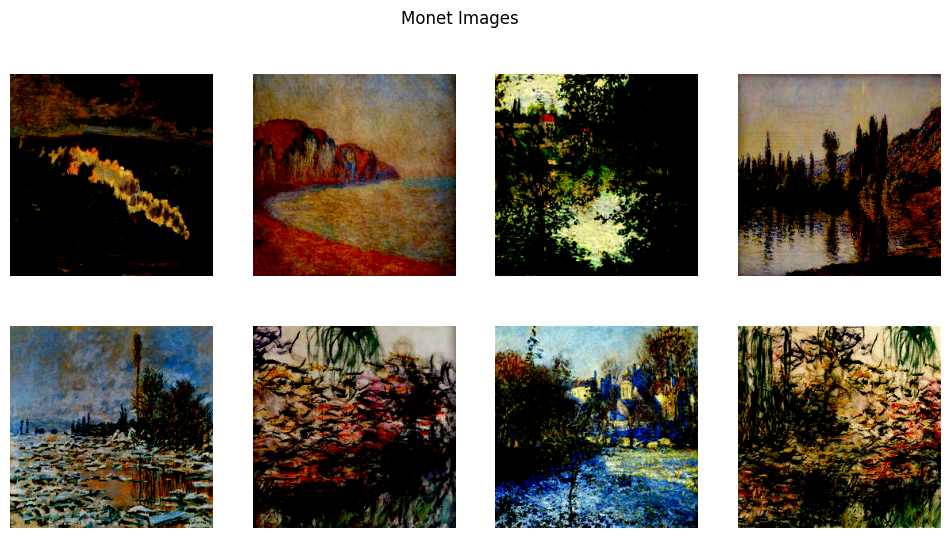

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB dat

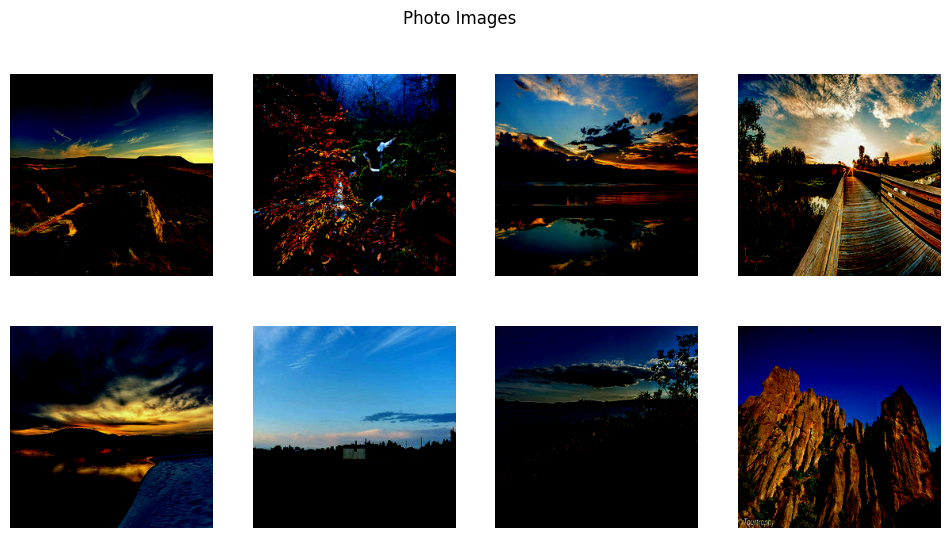

In [5]:
# display sample monet images

def show_batch(dataset, title):
    plt.figure(figsize=(12, 6))
    for i, image in enumerate(dataset.take(1)):
        for j in range(min(8, image.shape[0])):  # show up to 8 images
            ax = plt.subplot(2, 4, j + 1)
            plt.imshow(image[j])
            plt.axis("off")
        plt.suptitle(title)
        plt.show()

show_batch(monetTrain, "Monet Images")
show_batch(photoTrain, "Photo Images")

Colors of both photos and monet images are both widely varied. These are just random sample images for readers to visualize

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


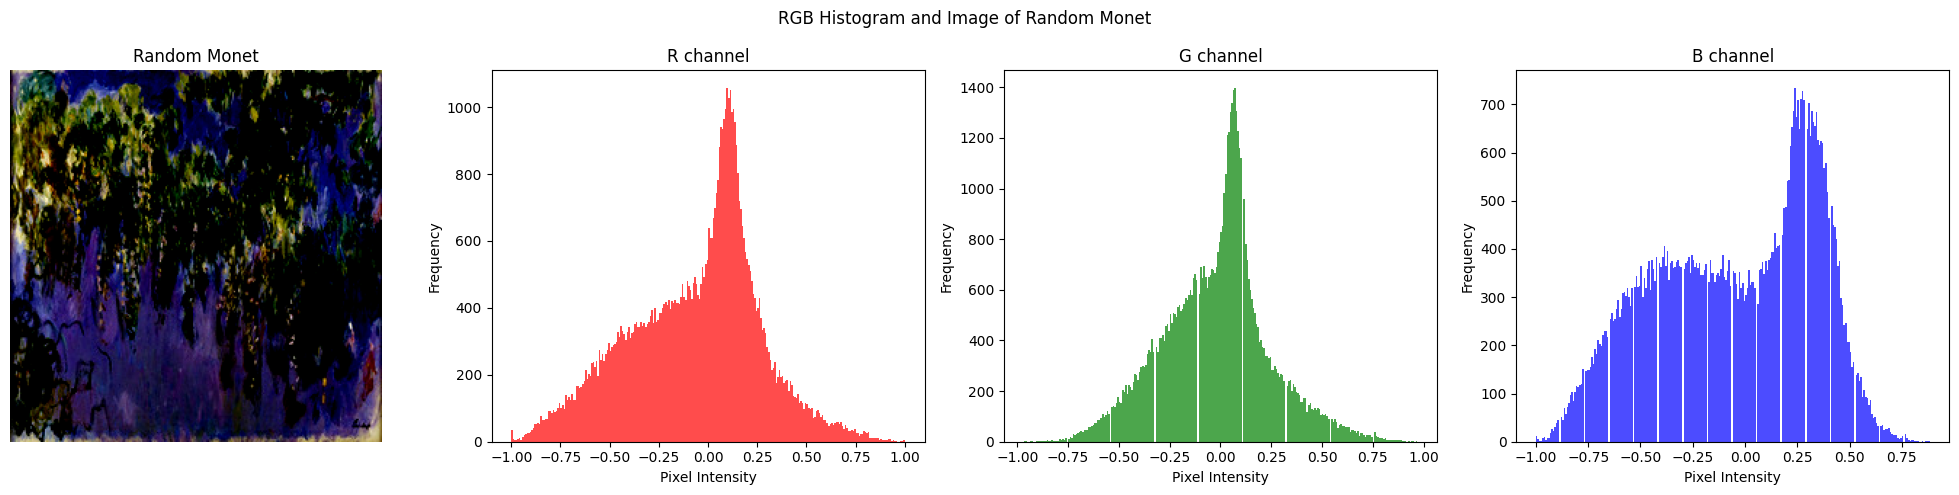

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


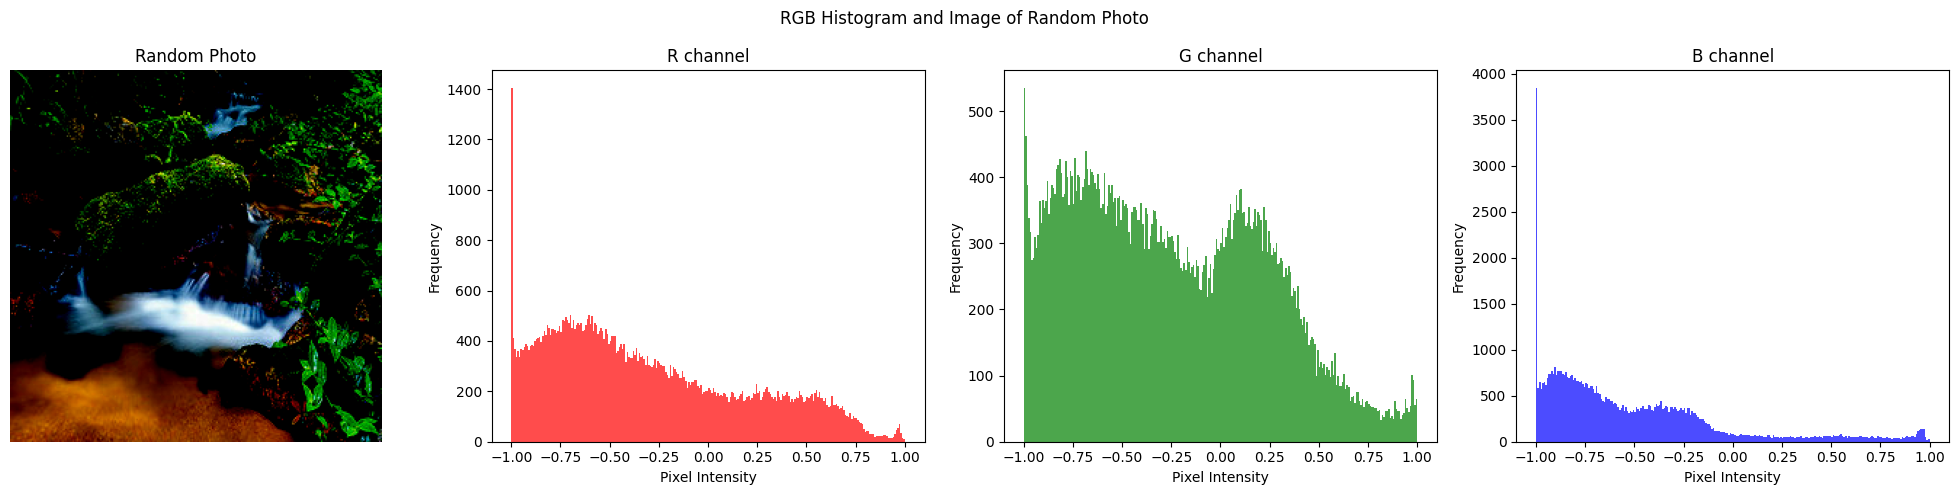

In [6]:
# histogram of pixel color distribution between red green and blue

def plotRGBHist(image, title):
    colors = ('r', 'g', 'b')
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # 1 row, 4 columns

    # show image
    axes[0].imshow(image)
    axes[0].axis('off')
    axes[0].set_title('Random ' + title)

    # show histogram subplots
    for i, color in enumerate(colors):
        axes[i+1].hist(image[:, :, i].flatten(), bins=256, color=color, alpha=0.7)
        axes[i+1].set_title(f'{color.upper()} channel')
        axes[i+1].set_xlabel('Pixel Intensity')
        axes[i+1].set_ylabel('Frequency')

    fig.suptitle('RGB Histogram and Image of Random ' + title)
    plt.tight_layout()
    plt.show()

photoList = list(photoTrainUnbatched.as_numpy_iterator())
monetList = list(monetTrainUnbatched.as_numpy_iterator())

randomPhoto = random.choice(photoList)
randomMonet = random.choice(monetList)

plotRGBHist(randomMonet, 'Monet')
plotRGBHist(randomPhoto, 'Photo')


The color distribution between red, green, and blue seem to vary from picture to picture which will make training this cycle GAN model interesting. None of the pictures seem to be biased as they represent their respective images shown on the left. The -1 pixel intensity represent darker tones of that color and the 1 represents lighter tones of that color. Photos seem to trend towards having darker pixel colors wheras monet paints seem to trend towards lighter color pixels. Might mean that monet images are more colorful than actual photos. This seems to be true based off the random image samples above.

## Data Cleaning

- resize images to be 256 by 256 pixels for consistency

In [7]:
# resize images to be 256 x 256 for consistency
def resize_images(photo):
    return tf.image.resize(photo, (256, 256))

def resize_monet(monet):
    return tf.image.resize(monet, (256, 256))

photoTrain = photoTrain.map(lambda photo: resize_images(photo))
monetTrain = monetTrain.map(lambda photo: resize_monet(photo))

## Analysis / Results

### Model Architecture
The model that will be built is a cycleGAN architecture. Essentially it is a GAN model which includes a generator neural network and a discriminator neural network. There will be two generators and two discriminators. One generator translates from monet image to photo and the other translates from photos to monet style images. One discriminator will determine the loss from translating photos to monet and the other will determine the loss from translating monet to photos. A cycleGAN is suitable for this problem because it excels at translating images into different domains and the goal is to translate the photos into monet style paintings. It cycles by translating it to one domain and translates it back (reason for needing 2 generators and 2 discriminators) to ensure a consistent cycle.

Loss functions that will be evaluated are the adversarial loss and cycle consistency loss along with the generator and discriminator loss. The adversarial loss measures the mse (mean squared error) of the discriminator output and the true label. The cycle consistency loss is to measure l1 loss between the original image and the generated image, essentially measuring how well it matches the original after transfering it back and forth. The generator loss evaluates how well it is doing at fooling each other into thinking it is a photo and not a monet painting or vice versa. The discriminator loss evaluates how well it can distinguish between real or fake generated images. The variable total gen loss encapulates all these losses while training and will be our metric.

In [8]:
# generator model

def make_gen_model():
    inputs = tf.keras.Input(shape=(256, 256, 3))
    
    # downsampling
    generator = layers.Conv2D(64, kernel_size=7, strides=1, padding='same')(inputs)
    generator = layers.LayerNormalization()(generator)
    generator = layers.Activation('relu')(generator)

    generator = layers.Conv2D(128, kernel_size=3, strides=2, padding='same')(generator)
    generator = layers.LayerNormalization()(generator)
    generator = layers.Activation('relu')(generator)

    generator = layers.Conv2D(256, kernel_size=3, strides=2, padding='same')(generator)
    generator = layers.LayerNormalization()(generator)
    generator = layers.Activation('relu')(generator)

    # residual blocks
    for _ in range(6):
        res = generator
        generator = layers.Conv2D(256, kernel_size=3, strides=1, padding='same')(generator)
        generator = layers.LayerNormalization()(generator)
        generator = layers.Activation('relu')(generator)
        generator = layers.Conv2D(256, kernel_size=3, strides=1, padding='same')(generator)
        generator = layers.LayerNormalization()(generator)
        generator = layers.add([generator, res])

    # upsampling
    generator = layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(generator)
    generator = layers.LayerNormalization()(generator)
    generator = layers.Activation('relu')(generator)

    generator = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')(generator)
    generator = layers.LayerNormalization()(generator)
    generator = layers.Activation('relu')(generator)

    # output layer
    outputs = layers.Conv2D(3, kernel_size=7, strides=1, padding='same', activation='tanh')(generator)

    return tf.keras.Model(inputs, outputs)

In [9]:
# discriminator model
def make_dis_model():
    inputs = tf.keras.Input(shape=(256, 256, 3))

    discriminator = layers.Conv2D(64, kernel_size=4, strides=2, padding='same')(inputs)
    discriminator = layers.LeakyReLU(0.2)(discriminator)

    discriminator = layers.Conv2D(128, kernel_size=4, strides=2, padding='same')(discriminator)
    discriminator = layers.LayerNormalization()(discriminator)
    discriminator = layers.LeakyReLU(0.2)(discriminator)

    discriminator = layers.Conv2D(256, kernel_size=4, strides=2, padding='same')(discriminator)
    discriminator = layers.LayerNormalization()(discriminator)
    discriminator = layers.LeakyReLU(0.2)(discriminator)

    discriminator = layers.Conv2D(512, kernel_size=4, strides=1, padding='same')(discriminator)
    discriminator = layers.LayerNormalization()(discriminator)
    discriminator = layers.LeakyReLU(0.2)(discriminator)

    outputs = layers.Conv2D(1, kernel_size=4, strides=1, padding='same')(discriminator)

    return tf.keras.Model(inputs, outputs)

In [10]:
# loss function in cycleGan

# adversarial loss
def advLoss(real, generated):
    return cross_entropy(tf.ones_like(generated), generated)

# cycle consistency loss
def cycleConLoss(real, cycled):
    return tf.reduce_mean(tf.abs(real - cycled))

# loss functions for generator and discriminator models
binaryCross = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def disLoss(real, generated):
    realLoss = binaryCross(tf.ones_like(real), real)
    genLoss = binaryCross(tf.zeros_like(generated), generated)
    return (realLoss + genLoss) * 0.5

def genLoss(generated):
    return binaryCross(tf.ones_like(generated), generated)

In [11]:
# training loop

# @tf.function # compiles the function
def train_step(photos, monets, epoch, genPhotoToMonet, genMonetToPhoto, disPhoto, disMonet, genMonetPhotoOpt, disMonetOpt, genPhotoMonetOpt, disPhotoOpt):
    with tf.GradientTape(persistent=True) as tape:
        # generate monet from photo and reconstruct photo
        fakeMonet = genPhotoToMonet(photos, training=True)
        cycledPhoto = genMonetToPhoto(fakeMonet, training=True)

        # generate photo from Monet and reconstruct monet
        fakePhoto = genMonetToPhoto(monets, training=True)
        cycledMonet = genPhotoToMonet(fakePhoto, training=True)

        # discriminator outputs
        disRealPhoto = disPhoto(photos, training=True)
        disRealMonet = disMonet(monets, training=True)

        disFakePhoto = disPhoto(fakePhoto, training=True)
        disFakeMonet = disMonet(fakeMonet, training=True)

        # generator adversarial losses
        genPhotoToMonetLoss = genLoss(disFakeMonet)
        genMonetToPhotoLoss = genLoss(disFakePhoto)

        # cycle consistency loss
        totalCycleLoss = cycleConLoss(photos, cycledPhoto) + cycleConLoss(monets, cycledMonet)

        # total generator losses
        totalGenPhotoToMonetLoss = genPhotoToMonetLoss + totalCycleLoss * lambdaCycle  * lambdaID
        totalGenMonetToPhotoLoss = genMonetToPhotoLoss + totalCycleLoss * lambdaCycle  * lambdaID
        
        totalGenLoss = genPhotoToMonetLoss + genMonetToPhotoLoss + totalCycleLoss
        
        # discriminator losses
        disPhotoLoss = disLoss(disRealPhoto, disFakePhoto)
        disMonetLoss = disLoss(disRealMonet, disFakeMonet)

    # calculate gradients
    genPhotoToMonetGradients = tape.gradient(totalGenPhotoToMonetLoss, genPhotoToMonet.trainable_variables)
    genMonetToPhotoGradients = tape.gradient(totalGenMonetToPhotoLoss, genMonetToPhoto.trainable_variables)

    disPhotoGradients = tape.gradient(disPhotoLoss, disPhoto.trainable_variables)
    disMonetGradients = tape.gradient(disMonetLoss, disMonet.trainable_variables)

    # apply gradients
    genPhotoMonetOpt.apply_gradients(zip(genPhotoToMonetGradients, genPhotoToMonet.trainable_variables))
    genMonetPhotoOpt.apply_gradients(zip(genMonetToPhotoGradients, genMonetToPhoto.trainable_variables))
    disPhotoOpt.apply_gradients(zip(disPhotoGradients, disPhoto.trainable_variables))
    disMonetOpt.apply_gradients(zip(disMonetGradients, disMonet.trainable_variables))

    print(totalGenLoss)
    return totalGenLoss

In [12]:
# generate and save images
def generateAndSaveImages(model, epoch, testInput):
    preds = model(testInput, training=False)

    fig = plt.figure(figsize=(8,8))

    for i in range(preds.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((preds[i] * 127.5 + 127.5).numpy().astype("uint8"))
        plt.axis('off')

    plt.savefig('generated_images/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [13]:
# plot function to plot the total gen loss at each epoch

def plotGenLossEpoch(genLossList):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(genLossList) + 1), genLossList, label='Gen Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Generator Loss Per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

In [14]:
# compiles and trains all models

def train(dataset, epochs, genPhotoToMonet, genMonetToPhoto, disPhoto, disMonet, seed):
    os.makedirs('best_model', exist_ok=True)
    bestGenLoss = 10000
    genLossList = []
    bestEpochGen = -1
    batchCount = sum(1 for _ in dataset)
    
    # gen and dis model optimizers
    genMonetPhotoOpt = tf.keras.optimizers.Adam(1e-4)
    disMonetOpt = tf.keras.optimizers.Adam(1e-4)
    genPhotoMonetOpt = tf.keras.optimizers.Adam(1e-4)
    disPhotoOpt = tf.keras.optimizers.Adam(1e-4)
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}, Processing Batch...")
        start = time.time()
        for batch_idx, (photoBatch, monetBatch) in enumerate(dataset):
            totalGenLoss = train_step(photoBatch, monetBatch, epoch, genPhotoToMonet, genMonetToPhoto, disPhoto, disMonet, genMonetPhotoOpt, 
                                      disMonetOpt, genPhotoMonetOpt, disPhotoOpt)
            genLossList.append(totalGenLoss)
            print(batch_idx, batchCount)
            # save best model
            if totalGenLoss < bestGenLoss:
                bestGenLoss = totalGenLoss
                bestEpochGen = epoch
                print(f"Saving best models at epoch {epoch} with GenLoss={totalGenLoss:.4f}")
                genPhotoToMonet.save('best_model/best_genPhotoToMonet.keras')
                genMonetToPhoto.save('best_model/best_genMonetToPhoto.keras')
            
        # generate sample images at each epoch
        display.clear_output(wait=True)
        generateAndSaveImages(genPhotoToMonet, epoch + 1, seed)
        
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate images after final epoch
    display.clear_output(wait=True)
    generateAndSaveImages(genPhotoToMonet, epochs, seed)
    plotGenLossEpoch(genLossList)
    print('best generative loss: ', bestGenLoss, ' at epoch: ', bestEpochGen)

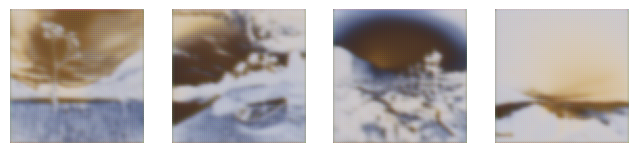

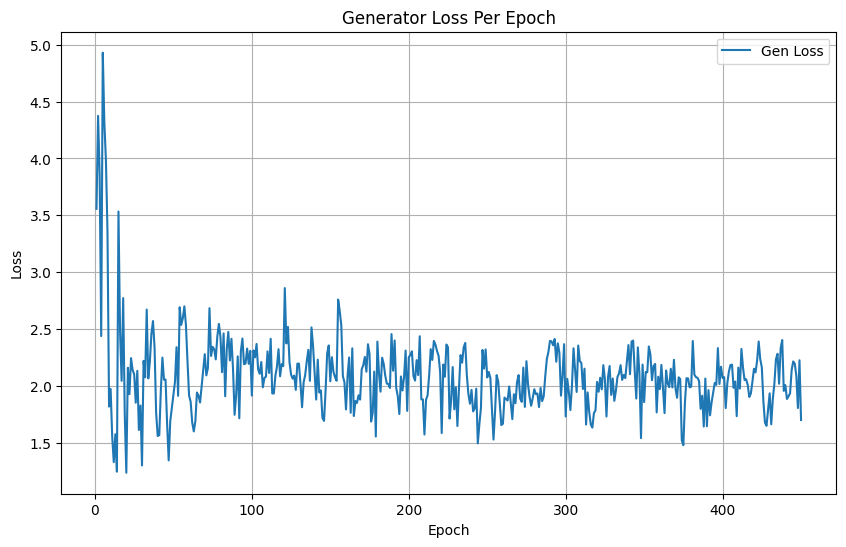

best generative loss:  tf.Tensor(1.2388132, shape=(), dtype=float32)  at epoch:  0


In [15]:
# compile: train the model

epochs = 3
numToGenerate = 4
lambdaCycle = 10.0
lambdaID = 0.5 * lambdaCycle

seed = tf.stack(list(photoTrainUnbatched.take(numToGenerate)))

batchSize = 2
# zip up photo and monet into a tensor flow dataset
dataset = tf.data.Dataset.zip((photoTrainUnbatched, monetTrainUnbatched)).batch(batchSize, drop_remainder=True)

# create the generator and discriminator models
genMonetToPhoto = make_gen_model()
genPhotoToMonet = make_gen_model()
disPhoto = make_dis_model()
disMonet = make_dis_model()

train(dataset, epochs, genPhotoToMonet, genMonetToPhoto, disPhoto, disMonet, seed)

In [16]:
# display image using epoch number
def display_image(epochNum):
  return PIL.Image.open('generated_images/image_at_epoch_{:04d}.png'.format(epochNum))
# display_image(epochs)

In [17]:
# load best performing model from earlier training and translate photos into monet style images

bestGenPhotoToMonet = models.load_model('best_model/best_genPhotoToMonet.keras', compile=False)
bestGenMonetToPhoto = models.load_model('best_model/best_genMonetToPhoto.keras', compile=False)


In [18]:
os.makedirs('submission', exist_ok=True)

for i, photo_batch in enumerate(photoTrain):
    monetImages = bestGenPhotoToMonet(photo_batch, training=False)
    
    for j in range(len(monetImages)):
        img = monetImages[j].numpy() # convert to np array
        img = np.clip(img,0,1)

        plt.imsave(f'submission/monet_style_{i * len(photo_batch) + j}.png', img)

        if (i * len(photo_batch) + j) % 1000 == 0: 
            print('photo ', i * len(photo_batch) + j, 'translated')

print('all photos translated')

photo  0 translated
photo  1000 translated
photo  2000 translated
photo  3000 translated
photo  4000 translated
photo  5000 translated
photo  6000 translated
all photos translated


## Hyperparameter Tuning

Things to tune:
- batch size 2 to 3, might influence training stability, generalization, training speed, memory usage, and lossage, so generally affects everything
- adding learning rate to optimizers from 0.0001 to 0.0002
- adding dropout layers into both generator and discriminator architecture at 0.5 to prevent overfitting
- epochs changed to 1, only testing 1 epoch

In [19]:
def make_gen_model():
    inputs = tf.keras.Input(shape=(256, 256, 3))
    
    generator = layers.Conv2D(64, kernel_size=7, strides=1, padding='same')(inputs)
    generator = layers.LayerNormalization()(generator)
    generator = layers.Activation('relu')(generator)
    generator = layers.Dropout(0.5)(generator) # add dropout layer

    generator = layers.Conv2D(128, kernel_size=3, strides=2, padding='same')(generator)
    generator = layers.LayerNormalization()(generator)
    generator = layers.Activation('relu')(generator)
    generator = layers.Dropout(0.5)(generator) # add dropout layer

    generator = layers.Conv2D(256, kernel_size=3, strides=2, padding='same')(generator)
    generator = layers.LayerNormalization()(generator)
    generator = layers.Activation('relu')(generator)
    generator = layers.Dropout(0.5)(generator) # add dropout layer

    for _ in range(6):
        res = generator
        generator = layers.Conv2D(256, kernel_size=3, strides=1, padding='same')(generator)
        generator = layers.LayerNormalization()(generator)
        generator = layers.Activation('relu')(generator)
        generator = layers.Conv2D(256, kernel_size=3, strides=1, padding='same')(generator)
        generator = layers.LayerNormalization()(generator)
        generator = layers.add([generator, res])

    generator = layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(generator)
    generator = layers.LayerNormalization()(generator)
    generator = layers.Activation('relu')(generator)

    generator = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')(generator)
    generator = layers.LayerNormalization()(generator)
    generator = layers.Activation('relu')(generator)

    outputs = layers.Conv2D(3, kernel_size=7, strides=1, padding='same', activation='tanh')(generator)

    return tf.keras.Model(inputs, outputs)

In [20]:
def make_dis_model():
    inputs = tf.keras.Input(shape=(256, 256, 3))

    discriminator = layers.Conv2D(64, kernel_size=4, strides=2, padding='same')(inputs)
    discriminator = layers.LeakyReLU(0.2)(discriminator)
    discriminator = layers.Dropout(0.5)(discriminator) # add dropout layer

    discriminator = layers.Conv2D(128, kernel_size=4, strides=2, padding='same')(discriminator)
    discriminator = layers.LayerNormalization()(discriminator)
    discriminator = layers.LeakyReLU(0.2)(discriminator)
    discriminator = layers.Dropout(0.5)(discriminator) # add dropout layer


    discriminator = layers.Conv2D(256, kernel_size=4, strides=2, padding='same')(discriminator)
    discriminator = layers.LayerNormalization()(discriminator)
    discriminator = layers.LeakyReLU(0.2)(discriminator)
    discriminator = layers.Dropout(0.5)(discriminator) # add dropout layer


    discriminator = layers.Conv2D(512, kernel_size=4, strides=1, padding='same')(discriminator)
    discriminator = layers.LayerNormalization()(discriminator)
    discriminator = layers.LeakyReLU(0.2)(discriminator)
    discriminator = layers.Dropout(0.5)(discriminator) # add dropout layer

    outputs = layers.Conv2D(1, kernel_size=4, strides=1, padding='same')(discriminator)

    return tf.keras.Model(inputs, outputs)

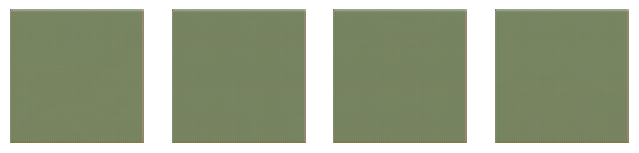

best generative loss:  tf.Tensor(1.3843741, shape=(), dtype=float32)  at epoch:  0


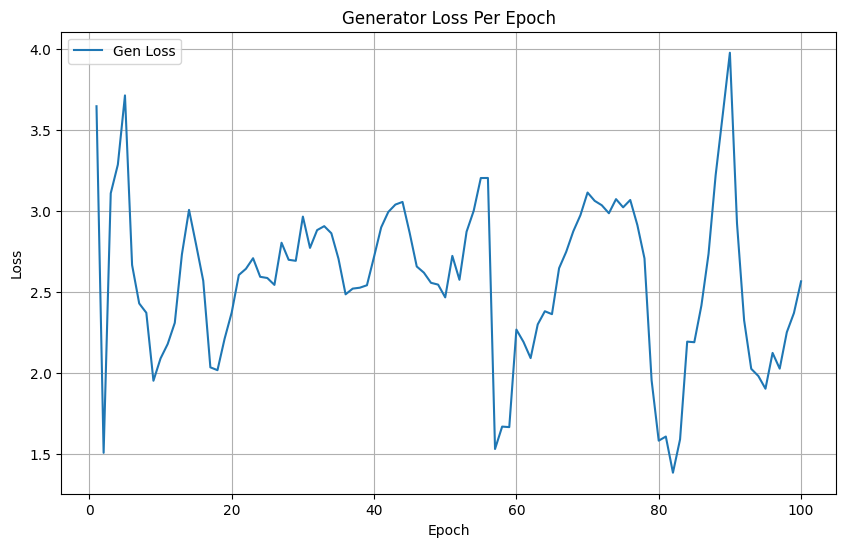

In [21]:
def HTtrain(dataset, epochs, genPhotoToMonet, genMonetToPhoto, disPhoto, disMonet, seed):
    os.makedirs('best_model2', exist_ok=True)
    bestGenLoss = 10000
    genLossList = []
    bestEpochGen = -1
    batchCount = sum(1 for _ in dataset)
    
    genMonetPhotoOpt = tf.keras.optimizers.Adam(0.0002,) # added learning rate of 0.0002
    disMonetOpt = tf.keras.optimizers.Adam(0.0002) # added learning rate of 0.0002
    genPhotoMonetOpt = tf.keras.optimizers.Adam(0.0002) # added learning rate of 0.0002
    disPhotoOpt = tf.keras.optimizers.Adam(0.0002) # added learning rate of 0.0002
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}, Processing Batch...")
        start = time.time()
        for batch_idx, (photoBatch, monetBatch) in enumerate(dataset):
            totalGenLoss = train_step(photoBatch, monetBatch, epoch, genPhotoToMonet, genMonetToPhoto, disPhoto, disMonet, genMonetPhotoOpt, 
                                      disMonetOpt, genPhotoMonetOpt, disPhotoOpt)
            genLossList.append(totalGenLoss)
            print(batch_idx, batchCount)
            if totalGenLoss < bestGenLoss:
                bestGenLoss = totalGenLoss
                bestEpochGen = epoch
                print(f"Saving best models at epoch {epoch} with GenLoss={totalGenLoss:.4f}")
                genPhotoToMonet.save('best_model2/best_genPhotoToMonet.keras')
                genMonetToPhoto.save('best_model2/best_genMonetToPhoto.keras')
            
        display.clear_output(wait=True)
        generateAndSaveImages(genPhotoToMonet, epoch + 1, seed)
        
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    display.clear_output(wait=True)
    generateAndSaveImages(genPhotoToMonet, epochs, seed)
    print('best generative loss: ', bestGenLoss, ' at epoch: ', bestEpochGen)
    plotGenLossEpoch(genLossList)


epochs = 1 # change to 1
numToGenerate = 4 # keep at 4 don't want to generate more
lambdaCycle = 10.0
lambdaID = 0.5 * lambdaCycle

seed = tf.stack(list(photoTrainUnbatched.take(numToGenerate)))

batchSize = 3 # change from 2 to 3
dataset = tf.data.Dataset.zip((photoTrainUnbatched, monetTrainUnbatched)).batch(batchSize, drop_remainder=True)

genMonetToPhoto = make_gen_model()
genPhotoToMonet = make_gen_model()
disPhoto = make_dis_model()
disMonet = make_dis_model()

HTtrain(dataset, epochs, genPhotoToMonet, genMonetToPhoto, disPhoto, disMonet, seed)

In [24]:
# summary table of best performing cycleGAN model

print("Best Generator Model Summary:")
bestGenPhotoToMonet.summary()

Best Generator Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                 ┃ Output Shape             ┃        Param # ┃ Connected to              ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)   │ (None, 256, 256, 3)      │              0 │ -                         │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ conv2d_16 (Conv2D)           │ (None, 256, 256, 64)     │          9,472 │ input_layer_1[0][0]       │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ layer_normalization_17       │ (None, 256, 256, 64)     │            128 │ conv2d_16[0][0]           │
│ (LayerNormalization)         │                          │                │                           │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ activation_11 (Activation)   │ (None, 256, 256, 64)     │              0 │ layer_normalization_17[0… │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ conv2d_17 (Conv2D)           │ (None, 128, 128, 128)    │         73,856 │ activation_11[0][0]       │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ layer_normalization_18       │ (None, 128, 128, 128)    │            256 │ conv2d_17[0][0]           │
│ (LayerNormalization)         │                          │                │                           │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ activation_12 (Activation)   │ (None, 128, 128, 128)    │              0 │ layer_normalization_18[0… │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ conv2d_18 (Conv2D)           │ (None, 64, 64, 256)      │        295,168 │ activation_12[0][0]       │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ layer_normalization_19       │ (None, 64, 64, 256)      │            512 │ conv2d_18[0][0]           │
│ (LayerNormalization)         │                          │                │                           │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ activation_13 (Activation)   │ (None, 64, 64, 256)      │              0 │ layer_normalization_19[0… │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ conv2d_19 (Conv2D)           │ (None, 64, 64, 256)      │        590,080 │ activation_13[0][0]       │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ layer_normalization_20       │ (None, 64, 64, 256)      │            512 │ conv2d_19[0][0]           │
│ (LayerNormalization)         │                          │                │                           │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ activation_14 (Activation)   │ (None, 64, 64, 256)      │              0 │ layer_normalization_20[0… │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ conv2d_20 (Conv2D)           │ (None, 64, 64, 256)      │        590,080 │ activation_14[0][0]       │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ layer_normalization_21       │ (None, 64, 64, 256)      │            512 │ conv2d_20[0][0]           │
│ (LayerNormalization)         │                          │                │                           │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ add_6 (A

 Total params: 7,845,123 (29.93 MB)

 Trainable params: 7,845,123 (29.93 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
print("Best Discriminator Model Summary:")
bestGenMonetToPhoto.summary()

Best Discriminator Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                 ┃ Output Shape             ┃        Param # ┃ Connected to              ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)     │ (None, 256, 256, 3)      │              0 │ -                         │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ conv2d (Conv2D)              │ (None, 256, 256, 64)     │          9,472 │ input_layer[0][0]         │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ layer_normalization          │ (None, 256, 256, 64)     │            128 │ conv2d[0][0]              │
│ (LayerNormalization)         │                          │                │                           │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ activation (Activation)      │ (None, 256, 256, 64)     │              0 │ layer_normalization[0][0] │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ conv2d_1 (Conv2D)            │ (None, 128, 128, 128)    │         73,856 │ activation[0][0]          │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ layer_normalization_1        │ (None, 128, 128, 128)    │            256 │ conv2d_1[0][0]            │
│ (LayerNormalization)         │                          │                │                           │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ activation_1 (Activation)    │ (None, 128, 128, 128)    │              0 │ layer_normalization_1[0]… │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ conv2d_2 (Conv2D)            │ (None, 64, 64, 256)      │        295,168 │ activation_1[0][0]        │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ layer_normalization_2        │ (None, 64, 64, 256)      │            512 │ conv2d_2[0][0]            │
│ (LayerNormalization)         │                          │                │                           │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ activation_2 (Activation)    │ (None, 64, 64, 256)      │              0 │ layer_normalization_2[0]… │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ conv2d_3 (Conv2D)            │ (None, 64, 64, 256)      │        590,080 │ activation_2[0][0]        │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ layer_normalization_3        │ (None, 64, 64, 256)      │            512 │ conv2d_3[0][0]            │
│ (LayerNormalization)         │                          │                │                           │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ activation_3 (Activation)    │ (None, 64, 64, 256)      │              0 │ layer_normalization_3[0]… │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ conv2d_4 (Conv2D)            │ (None, 64, 64, 256)      │        590,080 │ activation_3[0][0]        │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ layer_normalization_4        │ (None, 64, 64, 256)      │            512 │ conv2d_4[0][0]            │
│ (LayerNormalization)         │                          │                │                           │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ add (Add

 Total params: 7,845,123 (29.93 MB)

 Trainable params: 7,845,123 (29.93 MB)

 Non-trainable params: 0 (0.00 B)

Summary: Some visualizations provided were summary tables of both the best generator and discriminator models, and line plots showing the total generator loss (which includes the gen + dis + cycle consistency losses). The total generator loss for the cycleGAN model before tuning was 1.2388132 while after tuning it was 1.3843741. It actually decreased after hyperparameter tuning the batch size, learning rate, dropout layers, and epochs and thus performed worse. The first pretuned line plot actually showed the gen loss at each batch instead of epoch. But it generally peaked early before the 100th batch and continued flucuating afterwards slightly higher for the remaining batches. The tuned lineplot showed the gen loss peaking around the end a little bit past 80 batches. 

Hyperparameters that did not work well: Tuning the epochs did not work well because it allowed less batches to be trained I think. It did not have enough batches or epochs to train on the image data. I also think that adding the dropout layers did not work well because it might have made some colors overfit, adding bias to the models. Previously I did not have the dropout layer and it was fitting somewhat nicely, generating a coherent picture with multiple colors.

Troubleshooting: There were many issues. At first I tried using a DCGAN model but I realized that the goal of the competition was to translate images so I had to pivot to using a cycleGAN model. It was difficult figuring out the structure of the tfrec files. There was one instance where the dimensions would not line up when I passed the dataset into the train function, I realized I needed to unbatch the dataset for it to be in the correct format. A big thing I needed to troubleshoot was getting the generator and discriminator models to work. At one point the images generated were entirely tinted to be one color, showing extreme bias. What I ended up doing was figuring out that I had passed the batched data into be train instead of the unbatched data (it would be batched later) but it had to be unbatched first at one point.

Hyperparameter optimization procedure summary is listed at the hyperparameter tuning section.




## Conclusion/results: 
Some visualizations provided were summary tables of both the best generator and discriminator models, and line plots showing the total generator loss (which includes the gen + dis + cycle consistency losses). In the end hyperparameter tuning the model made the performance worse as the gen loss was higher, not sure what hyperparameter caused it to increase. 

Learning and Takeaways: What I learned was how the cycleGAN and DCGAN architecture worked. I learned when to use cycleGAN (when translating images to another dimension) and when to use DCGAN (generating new images from nothing). 

Something that did not work was like I mentioned earlier using the DCGAN architecture since that generates from random noise instead of translating images. So figuring out which architecture was something I struggled to do. Something else that did not work was hypertuning some variables, I am not sure which one caused my hyperparameter tuned model to not be able to generate images as well. During tuning I changed so many variables I am not sure which variable caused the model to break down.

Suggestions: One thing I would like to try is to increase the number of epochs to train, since my computer and time is limited 3 was the best I could do. Doing more epochs might result in less overfitting and better generalization. 

# Resources
 - https://www.tensorflow.org/tutorials/generative/dcgan
 - https://www.kaggle.com/competitions/gan-getting-started